In [30]:
import gdxpds
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [31]:
scenarios = list(['nodal', 'with_instrument', 'agnostic_instrument', 'without_instrument']);

nodes = list(['north', 'south'])

In [32]:
def read_data(file, indicator):
    gams_dir='C:\Program Files\GAMS'
    df = gdxpds.to_dataframes(str(file) + '.gdx', gams_dir=gams_dir)
    df = df[indicator]
    df['model'] = file
    if 'Level' in df.columns:
        df['Value'] = df['Level']
    df['Value'] = df['Value'].round(2)
    return(df.set_index(['model']))


def read_old(indicator, add = 'prefix'):
    if add == 'prefix':
        df = read_data('Zonal', 'o_' + indicator).append(read_data('Capacity instrument', 'o_' + indicator)).append(read_data('Nodal', 'o_' +  indicator))
        return(df)
    
    elif add == 'prefix_linearized':
        df = read_data('Zonal', 'o_' + indicator).append(read_data('Capacity instrument', 'o_' + indicator)).append(read_data('Capacity instrument linearized', 'i_' + indicator)).append(read_data('Nodal', 'o_' +  indicator))
        return(df)
    
    elif add == None:
        df = read_data('Capacity instrument', indicator).append(read_data('Nodal', indicator)).append(read_data('Zonal', indicator))
        df = df[['tec', 't', 'n', 'Value']]
        return(df)



def read(indicator):
    df = read_data(scenarios[0], indicator).append(read_data(scenarios[1], indicator)).append(read_data(scenarios[2], indicator)).append(read_data(scenarios[3], indicator))
    return(df)
    
def plot_distribution(df, axes, location):
    
    width = 0.8
    #baseload
    
    tmp = df.loc[df['tec'] == 'base'][location].fillna(0)
    tmp = tmp.reindex(index = scenarios)
    leg = axes.barh(y_pos, tmp, width, align='center', color = 'darkred')
    left = tmp.fillna(0)

    #peaker
    tmp = df.loc[df['tec'] == 'peak'][location].fillna(0)
    tmp = tmp.reindex(index = scenarios)
    axes.barh(y_pos, tmp, width, left=left, align='center', color = 'black')
    left = left + tmp.fillna(0)

    #wind
    tmp = df.loc[df['tec'] == 'wind'][location].fillna(0)
    tmp = tmp.reindex(index = scenarios)
    axes.barh(y_pos, tmp, width, left=left, align='center', color = 'lightblue')
    left = left + tmp.fillna(0)

    #solar
    tmp = df.loc[df['tec'] == 'solar'][location].fillna(0)
    tmp = tmp.reindex(index = scenarios)
    axes.barh(y_pos, tmp, width, left=left, align='center', color = 'gold')
    left = left + tmp.fillna(0)
    #leg.legend()
    return(axes)

    

In [33]:
df = read('o_gen')
df = df.reset_index().set_index(['model','t', 'n','tec'])
df = df.swaplevel().unstack()
df.columns = df.columns.droplevel(0)
df.columns.name = ''

df = df.groupby(['model','tec']).sum()
df = df.reset_index().set_index(['model'])
gen = df

In [34]:
gen

,tec,north,south
model,,,
agnostic_instrument,base,0.00,809.62
agnostic_instrument,solar,0.00,242.36
agnostic_instrument,wind,413.07,0.00
nodal,base,67.64,566.49
nodal,peak,7.76,8.12
nodal,solar,0.00,286.00
nodal,wind,434.57,119.20
without_instrument,base,382.25,396.41
without_instrument,solar,0.00,163.64


In [35]:
sums = gen.groupby(['model']).sum()
sums['total'] = sums[nodes[0]] + sums[nodes[1]]
sums = sums /48 * 8760
sums['share north'] = sums[nodes[0]] / sums['total']
sums
# in GWh

,north,south,total,share north
model,,,,
agnostic_instrument,75385.275,191986.350,267371.625,0.281949
nodal,93069.525,178815.325,271884.850,0.342312
without_instrument,165025.625,102209.125,267234.750,0.617531


# Installed capacities

In [36]:
df = read('o_cap')
df = df.reset_index().set_index(['model', 'n','tec'])
df = df.swaplevel().unstack()
df.columns = df.columns.droplevel(0)
df.columns.name = ''
df = df.reset_index().set_index(['model'])
capacities = df

In [37]:
capacities

,tec,north,south
model,,,
agnostic_instrument,base,NaN,40.44
agnostic_instrument,solar,NaN,84.74
agnostic_instrument,wind,79.13,NaN
nodal,base,4.82,30.46
nodal,peak,1.13,1.60
nodal,solar,NaN,100.00
nodal,wind,87.47,31.11
without_instrument,base,18.88,18.88
without_instrument,solar,NaN,57.22


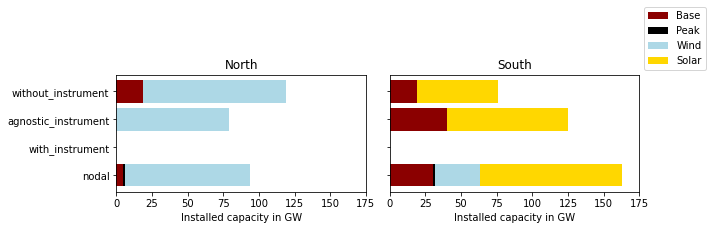

In [38]:
#plt.rcdefaults()
fig = plt.figure(figsize=(10, 3.3))

ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)

y_pos = np.arange(len(scenarios))
#leg = pd.Dataframe()

plot_distribution(capacities, ax1, 'north')
axes = plot_distribution(capacities, ax2, 'south')

ax1.set_xlim(0, 175)
ax2.set_xlim(0, 175)

ax1.set_title('North')
ax2.set_title('South')
                        
ax2.legend(['Base', 'Peak', 'Wind', 'Solar'], bbox_to_anchor=(1.0, 1))
#ax1.legend(['Base', 'Peak', 'Wind', 'Solar'])
ax1.set_yticks(y_pos);
ax1.set_yticklabels(scenarios); # ['First-best', 'Second-best', 'Single market zone']
ax2.set_yticklabels([]);
ax1.set_xlabel('Installed capacity in GW')
ax2.set_xlabel('Installed capacity in GW')
plt.tight_layout()

fig.savefig('capacity_distribution.jpeg', dpi=500)

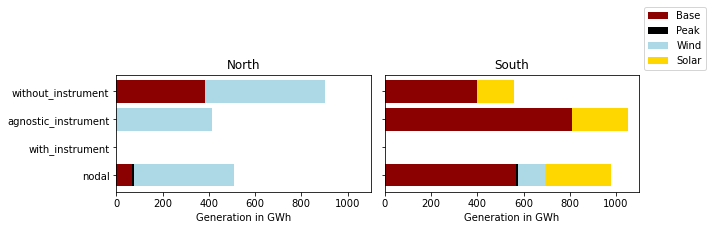

In [39]:
# plot generation
#plt.rcdefaults()
fig = plt.figure(figsize=(10, 3.3))

ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)

y_pos = np.arange(len(scenarios))
#leg = pd.Dataframe()

plot_distribution(gen, ax1, nodes[0])
axes = plot_distribution(gen, ax2, nodes[1])

ax1.set_xlim(0, 1100)
ax2.set_xlim(0, 1100)

ax1.set_title('North')
ax2.set_title('South')
                        
ax2.legend(['Base', 'Peak', 'Wind', 'Solar'], bbox_to_anchor=(1.0, 1))
#ax1.legend(['Base', 'Peak', 'Wind', 'Solar'])
ax1.set_yticks(y_pos);
ax1.set_yticklabels(scenarios); #['Nodal market', 'Locational instrument', 'Single market zone']);
ax2.set_yticklabels([]);
ax1.set_xlabel('Generation in GWh')
ax2.set_xlabel('Generation in GWh')
plt.tight_layout()

fig.savefig('generation_distribution.jpeg', dpi=500)

# Welfare comparison

In [40]:
welfare = pd.DataFrame(index = scenarios, columns = ['Network cost', 'Generation cost', 'Gross consumer surplus'])

In [41]:
for scenario in scenarios:
    welfare.loc[scenario, 'Network cost'] = read_data(scenario, 'network_cost').iloc[0,0]
    welfare.loc[scenario, 'Generation cost'] = read_data(scenario, 'generation_costs').iloc[0,0]
    welfare.loc[scenario, 'Gross consumer surplus'] = read_data(scenario, 'consumer_surplus').iloc[0,0]

In [42]:
welfare['Welfare'] = welfare['Gross consumer surplus'] - welfare['Network cost'] - welfare['Generation cost'];
welfare['Welfare'] = welfare['Welfare']



In [43]:
welfare = welfare / 1000

In [44]:
welfare.style.format('{0:,.0f}')

,Network cost,Generation cost,Gross consumer surplus,Welfare
nodal,644,"34,577","106,668","71,447"
with_instrument,0,0,0,0
agnostic_instrument,"3,322","33,728","105,963","68,913"
without_instrument,"6,067","33,367","105,978","66,545"


In [45]:
print('welfare gains through instrument in %')
    
print(round((welfare['Welfare']['with_instrument'] - welfare['Welfare']['without_instrument']) / welfare['Welfare']['without_instrument'] * 100,2))

print('welfare gains through nodal pricing in %')
    
print(round((welfare['Welfare']['nodal'] - welfare['Welfare']['without_instrument']) / welfare['Welfare']['without_instrument'] * 100,2))

print('welfare loss through uniform signal in %')
    
print(round((welfare['Welfare']['with_instrument'] - welfare['Welfare']['agnostic_instrument']) / welfare['Welfare']['with_instrument'] * 100,2))


welfare gains through instrument in %
-100.0
welfare gains through nodal pricing in %
7.37
welfare loss through uniform signal in %
-inf


<ipython-input-45-a132f5c7e3e2>:11: RuntimeWarning: divide by zero encountered in double_scalars
  print(round((welfare['Welfare']['with_instrument'] - welfare['Welfare']['agnostic_instrument']) / welfare['Welfare']['with_instrument'] * 100,2))


# Instrument level

In [47]:
fixed_costs = read_data('with_instrument', 'c_fix').reset_index(drop = True).set_index(['tec','n']).unstack()
fixed_costs.columns = fixed_costs.columns.droplevel(0)

In [48]:
instr = read_data('with_instrument', 'i_instrument').reset_index(drop = True).set_index(['tec','n']).unstack()
instr.columns = instr.columns.droplevel(0)
#instrument.loc['wind','south'] = 0
instr = instr.round(1)

In [49]:
instr

n
tec


In [50]:
cap = read_data('with_instrument', 'o_cap').reset_index(drop = True).set_index(['tec','n']).unstack()
cap.columns = cap.columns.droplevel(0)
instr[cap.isna()] = np.nan

In [51]:
shares = round(100 *instr / fixed_costs,1)

In [52]:
shares = shares.rename(columns={'north':'north (share)', 'south': 'south (share)'})
shares.columns = shares.columns.droplevel(0)

ValueError: Cannot remove 1 levels from an index with 1 levels: at least one level must be left.

In [135]:
instrument = pd.concat([instr, shares], axis=1)
instrument = instrument.sort_index(axis = 1)

In [136]:
fixed_costs.columns = fixed_costs.columns.droplevel(0)
instrument['Fixed cost'] = fixed_costs['north']

In [19]:
format_dict = {'north':'{0:,.0f} €', 'north (share)': '{0:,.0f}%', 'south': '{0:,.0f} €', 'south (share)': '{0:,.0f}%', 'Fixed cost': '{0:,.0f} €'}
instrument.style.format(format_dict)

NameError: name 'instrument' is not defined

In [53]:
instr

n
tec


In [99]:
# marginal price adder
mpa = cap*50 / 1000
mpa = mpa.round(1)
mpa

n,north,south
tec,,
base,0.2,1.3
peak,0.3,0.1
solar,1.5,4.4
wind,2.5,2.0


In [94]:
costs = pd.concat([instrument, mpa], axis=1)

In [96]:
costs

n,north,north (share),south,south (share),Fixed cost,north,south
tec,,,,,,,
base,205.8,39.5,187.0,35.9,521.0,1.0,5.2
peak,19.9,11.4,21.2,12.1,175.0,1.0,0.4
solar,7.3,2.7,12.5,4.6,274.0,6.0,17.6
wind,181.2,38.9,-16.8,-3.6,466.0,10.0,7.9


In [95]:
costs['south rel'] = costs['south'] / costs['Fixed cost']

ValueError: cannot reindex from a duplicate axis

# testing

In [72]:
cap

n,north,south
tec,,
base,4.79,25.95
peak,5.14,1.89
solar,30.07,88.23
wind,49.87,39.45


In [74]:
instr

n,north,south
tec,,
base,205.8,187.0
peak,19.9,21.2
solar,7.3,12.5
wind,181.2,-16.8


In [76]:
total_revenues = cap*instr

In [77]:
total_revenues.sum().sum()

15676.856

In [80]:
total

,Network cost,Generation cost,Gross consumer surplus,Welfare
model,,,,
Zonal,80.0,308.0,1000.0,614.0
Capacity instrument,8.0,324.0,990.0,648.0
Nodal,4.0,328.0,998.0,668.0


In [38]:
df = capacities

In [39]:
location = 'east'

In [ ]:
plot_distribution(df, axes, location)

In [50]:
width = 0.8
#baseload
tmp = df.loc[df['tec'] == 'base'][location].fillna(0)
tmp = tmp.reindex(index = scenarios)

tmp.values



array([ 4.62, 10.65,  9.28,  9.37])

In [49]:
y_pos

array([0, 1, 2, 3])

In [51]:
leg = axes.barh(y_pos, tmp.values, width, align='center', color = 'darkred')
left = tmp

In [52]:
leg

<BarContainer object of 4 artists>